In [20]:
%load_ext autoreload
%autoreload 2

import duckdb
import matplotlib.pyplot as plt
import os
import pandas as pd
import pathlib
import unicodedata

from geobr import read_state

from ibge import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Initialize DuckDB connection
conn = duckdb.connect("plants.db")

In [12]:
df = conn.execute("""
    SELECT s.stateProvince, s.Species FROM 
    sibbr_piperaceae AS s, flora_especies_ameacadas AS f
    WHERE s.Species IN f.species2020 AND s.Species <> 'nan' AND s.stateProvince <> 'nan'
""").df()
display(df.head())

,stateProvince,Species
0,Espírito Santo,Piper laevicarpum
1,Espírito Santo,Piper duartei
2,Rio de Janeiro,Piper translucens
3,Rio de Janeiro,Piper halesiifolium
4,São Paulo,Peperomia itatiaiana


In [17]:
especies_por_estado = df.groupby('stateProvince').agg({
    'Species': 'nunique'  # Contar espécies únicas
}).reset_index()
especies_por_estado.columns = ['estado', 'n_especies']

print(especies_por_estado)

           estado  n_especies
0           Bahia           5
1  Espírito Santo           9
2     Mato Grosso           1
3    Minas Gerais           6
4          Paraná           2
5  Rio de Janeiro          13
6  Santa Catarina           1
7       São Paulo           7


In [ ]:
# Carregar mapa do Brasil
brasil = read_state(year=2020)

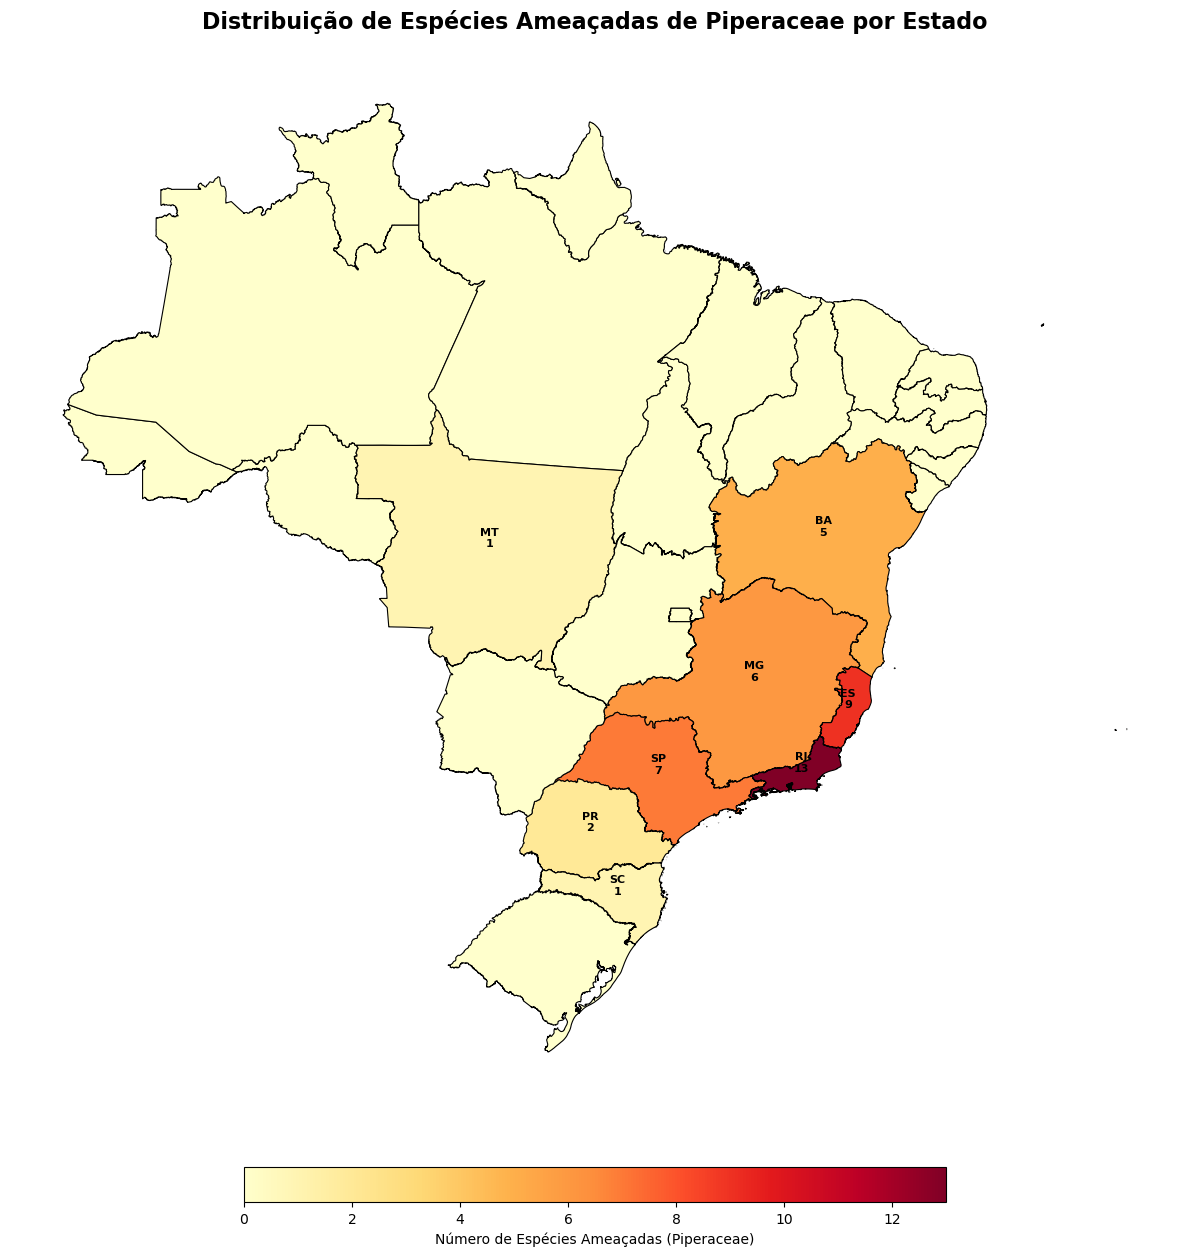

In [21]:
def normalize_str_py(s):
    if pd.isna(s):
        return None
    return ''.join(
        c for c in unicodedata.normalize('NFD', str(s))
        if unicodedata.category(c) != 'Mn'
    ).lower()

brasil['estado_norm'] = brasil['name_state'].apply(normalize_str_py)
especies_por_estado['estado_norm'] = especies_por_estado['estado'].apply(normalize_str_py)

# Merge dos dados
brasil_data = brasil.merge(especies_por_estado, on='estado_norm', how='left')
brasil_data['n_especies'] = brasil_data['n_especies'].fillna(0)

# Criar o heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

brasil_data.plot(
    column='n_especies',
    cmap='YlOrRd',  # Paleta amarelo-laranja-vermelho
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': "Número de Espécies Ameaçadas (Piperaceae)",
        'orientation': "horizontal",
        'shrink': 0.6,
        'pad': 0.05
    },
    ax=ax,
    missing_kwds={'color': 'lightgrey', 'label': 'Sem dados'}
)

for idx, row in brasil_data.iterrows():
    centroid = row.geometry.centroid
    n_esp = int(row['n_especies'])
    if n_esp > 0:
        ax.text(
            centroid.x, centroid.y, 
            f"{row['abbrev_state']}\n{n_esp}",
            fontsize=8, ha='center', weight='bold'
        )

ax.set_title('Distribuição de Espécies Ameaçadas de Piperaceae por Estado', 
             fontsize=16, weight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
# plt.savefig('heatmap_piperaceae_brasil.png', dpi=300, bbox_inches='tight')
plt.show()
